# Компьютерное зрение. Базовый курс

## Пространственная фильтрация изображений

### Медианный фильтр

#### Условие

* Реализуйте **3 алгоритма** медианного фильтра: простая сортировка, алгоритм Huang et al. (любая из модификаций), constant time O(1).

* Убедитесь в их работоспособности, результат их работы должен совпадать для всех изображений. Выбор изображений для экспериментов - на ваше усмотрение.

* Разрешается использовать готовые реализации алгоритмов сортировки из внешних библиотек.

* Постройте график зависимости времени работы алгоритмов (мсек/мегапиксель) от радиуса окна, для $R < 100$.

* Оцените фактическую асимптотику алгоритмов и требуемую память.

* Сравните свои реализации с имеющейся в библиотеке `OpenCV`.

* Предложите параметры для оптимальной композиции алгоритмов (например, $R < T$ - алгоритм A, иначе - алгоритм B).

* Для получения максимального балла за задание (20) **необходимо** прислать исходный код и полученные результаты: пример работы алгоритмов, графики времени работы, оценки фактической сложности, параметры для композиции алгоритмов.

#### Решение

Для работы с изображениями (методы, необходимые для чтения изображения из файла, записи изображения в файл и отображения изображения на экране, а также метод применения медианного фильтра к изображению) воспользуемся библиотекой `OpenCV`, а для более быстрой и эффективной работы с массивами - библиотекой `numpy`.

In [1]:
import cv2
import numpy as np

In [2]:
NUM_CHANNELS = 3
MIN_COMPONENT_VALUE = 0
MAX_COMPONENT_VALUE = 255

Медианный фильтр особенно эффективен для подавления шума salt-and-pepper, поэтому для дальнейших экспериментов реализуем функцию добавления такого искажения на исходное изображение.

In [3]:
def add_salt_and_pepper(orig_img, prob):
    rnd = np.random.rand(orig_img.shape[0], orig_img.shape[1])
    noisy_img = orig_img.copy().transpose((2, 0, 1))
    noisy_img[0][rnd < prob] = noisy_img[1][rnd < prob] = noisy_img[2][rnd < prob] = MIN_COMPONENT_VALUE
    noisy_img[0][rnd > 1 - prob] = noisy_img[1][rnd > 1 - prob] = noisy_img[2][rnd > 1 - prob] = MAX_COMPONENT_VALUE
    return noisy_img.transpose((1, 2, 0))

Для иллюстрации работы функции загрузим и сохраним оригинальное изображение, а затем добавим шум c вероятностью $noise\text{_}prob = 0.1$.

In [4]:
lenna_orig = cv2.imread('lenna_orig.jpeg', cv2.IMREAD_COLOR)
lenna_orig.shape

(400, 400, 3)

In [5]:
def viewImage(image, name_of_window):
    cv2.namedWindow(name_of_window, cv2.WINDOW_NORMAL)
    cv2.imshow(name_of_window, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [6]:
viewImage(lenna_orig,'lenna_orig')

In [7]:
noise_prob = 0.1

In [8]:
lenna_noisy = add_salt_and_pepper(orig_img=lenna_orig, prob=noise_prob)

In [9]:
viewImage(lenna_noisy,'lenna_noisy')

Теперь можно приступать к реализации алгоритмов медианного фильтра.

Заметим, что для корректной работы алгоритма с окном радиуса $R$ необходимо расширить границы изображения на $\frac {R - 1} {2}$ в каждую сторону (предполагаем, что $R$ - нечетное число), чтобы не упустить из рассмотрения пиксели на границе. Для дальнейшего удобства сравнения работы алгоритмов с реализацией в библиотеке `OpenCV` расширять границы изображения будем таким же способом, а именно: для расширения границы в одну из сторон дублировать нужное количество раз граничные пиксели с соответствующей стороны. Для расширения границы в смежных направлениях предлагается дублировать соответствующие угловые пиксели.

In [10]:
def make_border(img, depth=1):
    img = img.astype(np.int32)
    
    height_orig = img.shape[0]
    width_orig = img.shape[1]

    height = height_orig + 2 * depth
    width = width_orig + 2 * depth

    modified_img = np.zeros((height, width, 3))
    modified_img[depth:-depth, depth:-depth, :] = img

    for k in range(NUM_CHANNELS):
        for i in range(depth):
            for j in range(depth):
                modified_img[i][j][k] = modified_img[depth][depth][k]
                modified_img[i][width - j - 1][k] = modified_img[depth][width - depth - 1][k]
                modified_img[height - i - 1][j][k] = modified_img[height - depth - 1][depth][k]
                modified_img[height - i - 1][width - j - 1][k] = modified_img[height - depth - 1][width - depth - 1][k]

            for j in range(height_orig):
                modified_img[depth + j][i][k] = modified_img[depth + j][depth][k]
                modified_img[depth + j][width - i - 1][k] = modified_img[depth + j][width - depth - 1][k]

            for j in range(width_orig):
                modified_img[i][depth + j][k] = modified_img[depth][depth + j][k]
                modified_img[height - i - 1][depth + j][k] = modified_img[height - depth - 1][depth + j][k]
    
    return modified_img.astype('uint8')

Убедимся, что функция добавления границы работает корректно.

In [11]:
with_border_custom = make_border(img=lenna_orig, depth=50)
with_border_cv2 = cv2.copyMakeBorder(src=lenna_orig, top=50, bottom=50, left=50, right=50, borderType=cv2.BORDER_REPLICATE)
assert np.allclose(with_border_custom, with_border_cv2)

Результат работы алгоритма будем сравнивать с результатом работы функции `medianBlur` из библиотеки `OpenCV`. Для радиуса окна выберем значение $R = 7$ (значение для данного примера подобрано эмпирически, так, чтобы эффект от применения фильтра был наиболее наглядным).

In [12]:
%%time
cv2_result = cv2.medianBlur(lenna_noisy, 7)

CPU times: user 47 ms, sys: 0 ns, total: 47 ms
Wall time: 45.8 ms


In [13]:
viewImage(cv2_result, 'OpenCV Median Blur')

Для оценки асимптотик алгоритмов будем использовать следующие обозначения:

* $H$ - высота изображения;

* $W$ - ширина изображения;

* $R$ - радиус окна.

Отметим, что $R \leq H$ и $R \leq W$.

1. Алгоритм простой сортировки

Для каждого фрагмента изображения будем сортировать соответствующий набор пикселей каждого из трех каналов с помощью функции `np.sort` и выбирать медианные значения (можно, конечно, воспользоваться функцией `np.median`, но тогда будет сложно оценить асимптотику алгоритма). По умолчанию используется алгоритм быстрой сортировки, имеющий асимптотику $O(R^2 \log {R})$ (поскольку сортируется массив длины $R^2$).

In [14]:
def median_simple_sort(noisy_img, r=3):
    height = noisy_img.shape[0]
    width = noisy_img.shape[1]
    window_size = r ** 2
    median_index = window_size // 2
    border_depth = (r - 1) // 2

    framed_img = make_border(img=noisy_img, depth=border_depth).astype(np.int32).transpose((2, 0, 1))

    result = np.zeros((height, width, 3))

    for i in range(height):
        for j in range(width):
            for k in range(NUM_CHANNELS):
                result[i][j][k] = np.sort(framed_img[k, i:(i+r), j:(j+r)].reshape((window_size)))[median_index]

    return result.astype('uint8')

In [15]:
%%time
simple_sort_result = median_simple_sort(noisy_img=lenna_noisy, r=7)

CPU times: user 2.4 s, sys: 703 µs, total: 2.4 s
Wall time: 2.4 s


Сравним результат работы алгоритма с результатом работы функции `medianBlur`.

In [16]:
assert np.allclose(simple_sort_result, cv2_result)

Итоговая асимптотика алгоритма: $O (H W R^2 \log {R})$.

Дополнительная память нужна для хранения обрамленного изображения и текущего окна: $O ((H + R) (W + R) + R^2) = O (H W)$.

2. Алгоритм Huang et al.

In [17]:
def get_hist_median(hist, median_index):
    counter = 0
    for j in range(MAX_COMPONENT_VALUE + 1):
        counter += hist[j]
        if counter > median_index:
            counter -= hist[j]
            return counter, j

In [18]:
def median_huang(noisy_img, r=3):
    height = noisy_img.shape[0]
    width = noisy_img.shape[1]
    window_size = r ** 2
    median_index = window_size // 2
    border_depth = (r - 1) // 2

    curr_median = 0
    counter = 0 # the number of the elements less than the current median
    hist = dict.fromkeys(range(MAX_COMPONENT_VALUE + 1), 0)

    framed_img = make_border(img=noisy_img, depth=border_depth).astype(np.int32).transpose((2, 0, 1))

    result = np.zeros((height, width, 3))

    for i in range(height):
        for k in range(NUM_CHANNELS):
            for j in range(r):
                for s in range(r):
                    hist[framed_img[k][i + s][j]] += 1

            counter, curr_median = get_hist_median(hist, median_index)
            result[i][0][k] = curr_median

            for j in range(1, width):
                for s in range(r):
                    old_elem = framed_img[k][i + s][j - 1]
                    new_elem = framed_img[k][i + s][j + (r - 1)]

                    hist[old_elem] -= 1
                    hist[new_elem] += 1

                    counter -= old_elem < curr_median
                    counter += new_elem < curr_median

                if counter > median_index:
                    while counter > median_index:
                        curr_median -= 1
                        counter -= hist[curr_median]
                else:
                    while counter + hist[curr_median] <= median_index:
                        counter += hist[curr_median]
                        curr_median += 1

                result[i][j][k] = curr_median

            counter = 0
            hist = dict.fromkeys(range(MAX_COMPONENT_VALUE + 1), 0)

    return result.astype('uint8')

In [19]:
%%time
huang_result = median_huang(noisy_img=lenna_noisy, r=7)

CPU times: user 49.9 s, sys: 45 ms, total: 50 s
Wall time: 50.1 s


Сравним результат работы алгоритма с результатом работы функции `medianBlur`.

In [20]:
assert np.allclose(huang_result, cv2_result)

Итоговая асимптотика алгоритма: $O (H W R)$ (используется сортировка подсчетом, которая имеет сложность $O (R^2)$).

Дополнительная память нужна для хранения обрамленного изображения и гистограммы: $O ((H + R) (W + R) + 1) = O (H W)$.

3. Алгоритм Constant time.

In [21]:
def add_hist(window_hist, column_hist):
    for i in range(MAX_COMPONENT_VALUE + 1):
        window_hist[i] += column_hist[i]

In [22]:
def remove_hist(window_hist, column_hist):
    for i in range(MAX_COMPONENT_VALUE + 1):
        window_hist[i] -= column_hist[i]

In [23]:
def modify_column_hist(column_hist, old_elem, new_elem):
    column_hist[old_elem] -= 1
    column_hist[new_elem] += 1

In [24]:
def median_constant(noisy_img, r=3):
    height = noisy_img.shape[0]
    width = noisy_img.shape[1]
    window_size = r ** 2
    median_index = window_size // 2
    border_depth = (r - 1) // 2

    curr_median = 0

    framed_img = make_border(img=noisy_img, depth=border_depth).astype(np.int32).transpose((2, 0, 1))

    result = np.zeros((height, width, 3))

    for k in range(NUM_CHANNELS):
        column_hists = []
        for i in range(width + r - 1):
            column_hists.append(dict.fromkeys(range(MAX_COMPONENT_VALUE + 1), 0))
        
        #initializing column histograms
        for i in range(len(column_hists)):
            for j in range(r):
                column_hists[i][framed_img[k][j][i]] += 1

        # initializing window histogram
        window_hist = dict.fromkeys(range(MAX_COMPONENT_VALUE + 1), 0)

        # the first window in the first row
        for i in range(r):
            add_hist(window_hist, column_hists[i])

        _, result[0][0][k] = get_hist_median(window_hist, median_index)

        # the whole first row except first window
        for i in range(1, width):
            remove_hist(window_hist, column_hists[i - 1])
            add_hist(window_hist, column_hists[i + r - 1])
            _, result[0][i][k] = get_hist_median(window_hist, median_index)

        for i in range(1, height):
            
            #modifying column histograms for the first window in a row
            for j in range(r):
                modify_column_hist(column_hists[j], framed_img[k][i - 1][j], framed_img[k][i + r - 1][j])

            window_hist = dict.fromkeys(range(MAX_COMPONENT_VALUE + 1), 0)

            for j in range(r):
                add_hist(window_hist, column_hists[j])

            _, result[i][0][k] = get_hist_median(window_hist, median_index)

            for j in range(1, width):
                modify_column_hist(column_hists[j + r - 1], framed_img[k][i - 1][j + r - 1], framed_img[k][i + r - 1][j + r - 1])
                remove_hist(window_hist, column_hists[j - 1])
                add_hist(window_hist, column_hists[j + r - 1])
                _, result[i][j][k] = get_hist_median(window_hist, median_index)

    return result.astype('uint8')

In [25]:
%%time
constant_result = median_constant(noisy_img=lenna_noisy, r=7)

CPU times: user 30.6 s, sys: 4.12 ms, total: 30.6 s
Wall time: 30.6 s


Сравним результат работы алгоритма с результатом работы функции `medianBlur`.

In [26]:
assert np.allclose(constant_result, cv2_result)

Итоговая асимптотика алгоритма: $O (H W)$.

Дополнительная память нужна для хранения обрамленного изображения и набора гистограмм: $O ((H + R) (W + R) + W) = O (H W)$.

Запишем в файлы все изображения, полученные в результате работы алгоритмов (хоть уже и доказана их полная идентичность), а также изначальное зашумленное изображение.

In [43]:
cv2.imwrite('lenna_noisy.jpeg', lenna_noisy)

True

In [44]:
cv2.imwrite('lenna_opencv.jpeg', cv2_result)

True

In [45]:
cv2.imwrite('lenna_simple_sort.jpeg', simple_sort_result)

True

In [46]:
cv2.imwrite('lenna_huang.jpeg', huang_result)

True

In [47]:
cv2.imwrite('lenna_constant.jpeg', constant_result)

True

Теперь построим графики времени работы алгоритмов (мсек/мегапиксель) в зависимости от радиуса окна для $R < 100$. Для экспериментов будем использовать то же изображение, что и для проверки работоспособности алгоритмов. Значения $R$ будем полагать равными $3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 31, 41, 51, 71, 91$.

In [27]:
import time

In [28]:
def get_algorithms_time(noisy_img, r_values):
    simple_alg_time = []
    huang_alg_time = []
    constant_alg_time = []

    for r in r_values:
        start_time = time.time()
        median_simple_sort(noisy_img=lenna_noisy, r=r)
        finish_time = time.time()
        simple_alg_time.append(finish_time - start_time)

        start_time = time.time()
        median_huang(noisy_img=lenna_noisy, r=r)
        finish_time = time.time()
        huang_alg_time.append(finish_time - start_time)

        start_time = time.time()
        median_constant(noisy_img=lenna_noisy, r=r)
        finish_time = time.time()
        constant_alg_time.append(finish_time - start_time)

    return simple_alg_time, huang_alg_time, constant_alg_time

In [29]:
r_values = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 31, 41, 51, 71, 91]

In [31]:
simple_alg_time, huang_alg_time, constant_alg_time = get_algorithms_time(lenna_noisy, r_values)

Учтем, что полученные значения времени необходимо перевести в единицы измерения мсек/мегапиксель.

In [35]:
def convert_time(pixels_count, time_list):
    for i in range(len(time_list)):
        time_list[i] = time_list[i] / pixels_count * 1e9

In [36]:
pixels_count = lenna_orig.shape[0] * lenna_orig.shape[1]

In [37]:
convert_time(pixels_count, simple_alg_time)
convert_time(pixels_count, huang_alg_time)
convert_time(pixels_count, constant_alg_time)

Перейдем непосредственно к построению графиков.

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def plot_time(r_values, simple_alg_time, huang_alg_time, constant_alg_time):
    plt.figure(figsize=(12, 12))
    plt.plot(r_values, simple_alg_time, color='cornflowerblue', label='Алгоритм простой сортировки')
    plt.plot(r_values, huang_alg_time, color='mediumvioletred', label='Алгоритм Huang et al.')
    plt.plot(r_values, constant_alg_time, color='coral', label='Алгоритм Constant time')
    plt.xlabel('радиус окна R', fontsize=20)
    plt.ylabel('время, мсек/мегапиксель', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Графики времени работы алгоритмов в зависимости от радиуса окна", fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(alpha=0.5)
    plt.show()

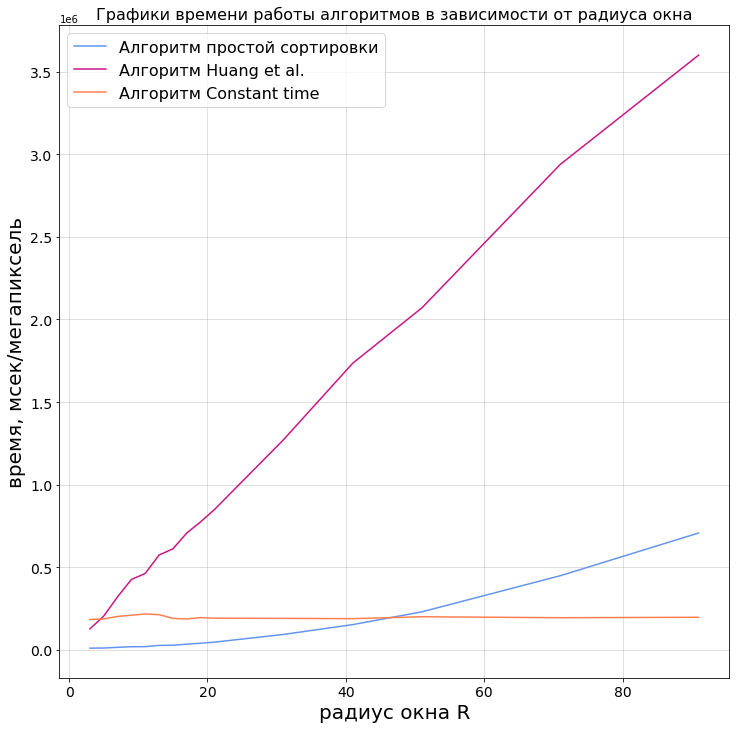

In [42]:
plot_time(r_values, simple_alg_time, huang_alg_time, constant_alg_time)

Из графика выше можно сделать вывод об оптимальных параметрах для композиции алгоритма:

* при $R \leq 50$ быстрее всего работает алгоритм простой сортировки;

* при $R > 50$ быстрее всего работает алгоритм Constant time.

Сделаем некоторые выводы о реализованных алгоритмах, исходя из кода и графика.

* Время работы алгоритма Constant time ожидаемо почти не зависит от радиуса окна, поскольку во всех случаях это значение много меньше габаритов самого изображения.

* Алгоритм Huang et al. асимптотически хуже алгоритма Constant time в $R$ раз, поэтому на графике наблюдается линейная зависимость от радиуса окна.

* Время работы алгоритма Constant time хуже времени работы алгоритма простой сортировки при малых $R$. Вероятная причина такого поведения - цикл по гистограмме размера $256$ ($> R^2 \log {R}$ при малых значениях $R$), в котором на каждой итерации перебирается число элементов, сравнимое с размером гистограммы.

* Также вполне возможно, что преимущество алгоритма простой сортировки по времени работы обусловлено некоторыми оптимизациями алгоритма сортировки массива в реализации библиотеки `numpy`. При использовании сортировок без оптимизаций пересечение желтой и синей линий произошло бы гораздо раньше, уже при $R \approx 10$. Кроме того, исходя из асимптотик, можно предположить, что в таком случае при $R \approx 60-70$ синяя и фиолетовая линии также пересеклись бы.

* Как бы то ни было, при больших значениях $R$ (т.е. при значениях, больших, по крайней мере, $50$) алгоритм Constant time однозначно превосходит по времени работы два других алгоритма.